In [1]:
import pandas as pd
import matplotlib.pyplot as plt

spx = pd.read_csv(
    "data/SPX.csv",
    sep=";",
    usecols=["Date", "Close"],
    parse_dates=["Date"]
)
spx["Date"] = pd.to_datetime(spx["Date"], format="mixed", dayfirst=False, errors="coerce")




spx = spx[["Date", "Close"]].rename(columns={"Close": "Price"})
spx = spx.sort_values("Date")


# Nur die ersten beiden Spalten einlesen, Header manuell setzen
kgv = pd.read_csv(
    "KGV.csv",
    sep=";",             # fest auf Semikolon setzen
    skiprows=1,          # erste Zeile ("Tabelle 1") überspringen
    usecols=[0, 1],      # nur Datum und KGV
    names=["Date", "PE Ratio"],  # eigene Spaltennamen
    header=None
)

# Datentypen bereinigen
kgv["Date"] = pd.to_datetime(kgv["Date"], errors="coerce")
kgv["PE Ratio"] = pd.to_numeric(kgv["PE Ratio"], errors="coerce")

# Aufräumen
kgv = kgv.dropna().sort_values("Date")


# Sicherstellen, dass Datumsspalten korrekt sind
spx["Date"] = pd.to_datetime(spx["Date"], format="mixed", dayfirst=False, errors="coerce")
spx["Price"] = spx["Price"].astype(str).str.replace(",", "").astype(float)

kgv["Date"] = pd.to_datetime(kgv["Date"])

# 1. Vollständigen täglichen Zeitraum erzeugen (von min bis max in SPX)
full_dates = pd.DataFrame({"Date": pd.date_range(start=spx["Date"].min(), end=spx["Date"].max(), freq="D")})

# 2. KGV auf vollen Datumsbereich mergen
kgv_full = full_dates.merge(kgv, on="Date", how="left")

# 3. Interpolation und Extrapolation (linear in beide Richtungen)
kgv_full["PE Ratio"] = kgv_full["PE Ratio"].interpolate(method="linear", limit_direction="both")

# 4. Auf SPX-Daten reduzieren (nur Tage mit Kursdaten)
kgv_on_spx_days = spx.merge(kgv_full, on="Date", how="left")

# 5. Ergebnis anzeigen
print(kgv_on_spx_days.tail())

            Date    Price  PE Ratio
24426 2025-03-31  5488.73  27.81871
24427 2025-04-01  5558.52  27.80000
24428 2025-04-02  5571.48  26.93000
24429 2025-04-03  5390.83  26.06000
24430 2025-04-04  5069.90  25.19000


/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_26763/1828262839.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  kgv["Date"] = pd.to_datetime(kgv["Date"], errors="coerce")


In [18]:
import pandas as pd

# Annahme: df ist dein bereits vorbereiteter DataFrame
df = kgv_on_spx_days.copy()
df = df.iloc[10000:].reset_index(drop=True)
# 1. 200-Tage-Linie berechnen
df["SMA_200"] = df["Price"].rolling(window=200).mean()

# 2. Tägliche Rendite berechnen
df["Daily Return"] = df["Price"].pct_change()

# 3. Portfoliowert berechnen
initial_value = 100
portfolio = [initial_value]  # erster Wert ist immer 100

for i in range(1, len(df)):
    if i < 200:
        # Noch nicht genug Daten für SMA – Portfolio bleibt gleich
        portfolio.append(initial_value)
    else:
        price_yesterday = df.iloc[i - 1]["Price"]
        sma_yesterday = df.iloc[i - 1]["SMA_200"]
        ret_today = df.iloc[i]["Daily Return"]

        if price_yesterday > sma_yesterday:
            # Investiert mit 3x Hebel
            new_value = portfolio[-1] * (1 + 3 * ret_today)
        else:
            # Konstantes Wachstum (z. B. Geldmarktzins o. Ä.)
            new_value = portfolio[-1] * (1 + 0.0001)

        portfolio.append(new_value)

# 4. Neue Spalte anhängen
df["Portfolio Value"] = portfolio

# 5. Rückgabe
df.tail(10)
#return:100*1,171^96,5

,Date,Price,PE Ratio,SMA_200,Daily Return,Portfolio Value
14421,2025-03-24,5718.08,27.949677,5721.44345,0.020521,9.066307e+06
14422,2025-03-25,5760.42,27.930968,5723.75735,0.007405,9.067214e+06
14423,2025-03-26,5694.41,27.912258,5725.55260,-0.011459,8.339890e+06
14424,2025-03-27,5670.94,27.893548,5727.25065,-0.004122,8.340724e+06
14425,2025-03-28,5572.42,27.874839,5728.45515,-0.017373,8.341558e+06
14426,2025-03-31,5488.73,27.818710,5729.26255,-0.015019,8.342393e+06
14427,2025-04-01,5558.52,27.800000,5730.00950,0.012715,8.343227e+06
14428,2025-04-02,5571.48,26.930000,5730.85435,0.002332,8.344061e+06
14429,2025-04-03,5390.83,26.060000,5730.78975,-0.032424,8.344896e+06
14430,2025-04-04,5069.90,25.190000,5729.03725,-0.059533,8.345730e+06


In [12]:
import pandas as pd

# Kopie des ursprünglichen DataFrames
df = kgv_on_spx_days.copy()

# 1. 200-Tage-Linie berechnen
df["SMA_200"] = df["Price"].rolling(window=200).mean()

# 2. Tägliche Rendite berechnen
df["Daily Return"] = df["Price"].pct_change()

# 3. Portfoliowert berechnen mit angepasster Reallokationslogik
initial_value = 100
portfolio = [initial_value]

# Tracking der Investitionslage (True = investiert)
invested = False

for i in range(1, len(df)):
    if i < 200:
        portfolio.append(initial_value)
        continue

    price_yesterday = df.iloc[i - 1]["Price"]
    sma_yesterday = df.iloc[i - 1]["SMA_200"]
    price_today = df.iloc[i]["Price"]
    sma_today = df.iloc[i]["SMA_200"]
    ret_today = df.iloc[i]["Daily Return"]

    # Default: kein Reallokationstag
    adjusted_return = ret_today

    # Prüfe, ob heute ein Abwärts-Durchbruch ist (Wechsel von investiert auf nicht investiert)
    if invested and (price_yesterday > sma_yesterday and price_today < sma_today):
        # Reallokation nach unten -> verwende statt ret_today die Differenz zum SMA
        adjusted_return = (sma_today - price_yesterday) / price_yesterday
        invested = False  # Ab jetzt nicht mehr investiert
    elif price_yesterday > sma_yesterday:
        invested = True
    else:
        invested = False

    # Portfolio-Update basierend auf Investitionsstatus
    if invested:
        new_value = portfolio[-1] * (1 + 3 * adjusted_return)
    else:
        new_value = portfolio[-1] * (1 + 0.0001)

    portfolio.append(new_value)

# 4. Neue Spalte anhängen
df["Portfolio Value"] = portfolio

# 5. Rückgabe
df.tail(10)



,Date,Price,PE Ratio,SMA_200,Daily Return,Portfolio Value
24421,2025-03-24,5718.08,27.949677,5721.44345,0.020521,1.513621e+13
24422,2025-03-25,5760.42,27.930968,5723.75735,0.007405,1.513772e+13
24423,2025-03-26,5694.41,27.912258,5725.55260,-0.011459,1.461732e+13
24424,2025-03-27,5670.94,27.893548,5727.25065,-0.004122,1.461879e+13
24425,2025-03-28,5572.42,27.874839,5728.45515,-0.017373,1.462025e+13
24426,2025-03-31,5488.73,27.818710,5729.26255,-0.015019,1.462171e+13
24427,2025-04-01,5558.52,27.800000,5730.00950,0.012715,1.462317e+13
24428,2025-04-02,5571.48,26.930000,5730.85435,0.002332,1.462463e+13
24429,2025-04-03,5390.83,26.060000,5730.78975,-0.032424,1.462610e+13
24430,2025-04-04,5069.90,25.190000,5729.03725,-0.059533,1.462756e+13


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

spx = pd.read_csv(
    "data/SPX.csv",
    sep=";",
    usecols=["Date", "Close"],
    parse_dates=["Date"]
)
spx["Date"] = pd.to_datetime(spx["Date"], format="mixed", dayfirst=False, errors="coerce")

spx = spx[["Date", "Close"]].rename(columns={"Close": "Price"})
spx = spx.sort_values("Date")
spx = spx.iloc[10000:].reset_index(drop=True)
spx["Price"] = spx["Price"].str.replace(",", "").astype(float)
spx["Change"] = spx["Price"].pct_change()


# Startwert für das Portfolio
initial_value = 100

# Hebel-Werte
leverage_factors = [1, 2, 3, 4]

# Für jeden Hebel eine neue Spalte berechnen
for lev in leverage_factors:
    spx[f"Leverage_{lev}x"] = initial_value * (1 + lev * spx["Change"]).cumprod()
spx.tail(10)

,Date,Price,Change,Leverage_1x,Leverage_2x,Leverage_3x,Leverage_4x
14421,2025-03-24,5718.08,0.020521,6050.878307,69561.079098,139916.499208,38593.501313
14422,2025-03-25,5760.42,0.007405,6095.682540,70591.220715,143024.569352,39736.576503
14423,2025-03-26,5694.41,-0.011459,6025.830688,68973.378099,138107.713382,37915.173608
14424,2025-03-27,5670.94,-0.004122,6000.994709,68404.818693,136400.044967,37290.091028
14425,2025-03-28,5572.42,-0.017373,5896.740741,66028.054793,129291.100543,34698.760653
14426,2025-03-31,5488.73,-0.015019,5808.179894,64044.755649,123465.782887,32614.252107
14427,2025-04-01,5558.52,0.012715,5882.031746,65673.432410,128175.439030,34273.031937
14428,2025-04-02,5571.48,0.002332,5895.746032,65979.674965,129071.983626,34592.669894
14429,2025-04-03,5390.83,-0.032424,5704.582011,61701.017128,116516.870528,30106.130722
14430,2025-04-04,5069.90,-0.059533,5364.973545,54354.576069,95707.221962,22936.948587


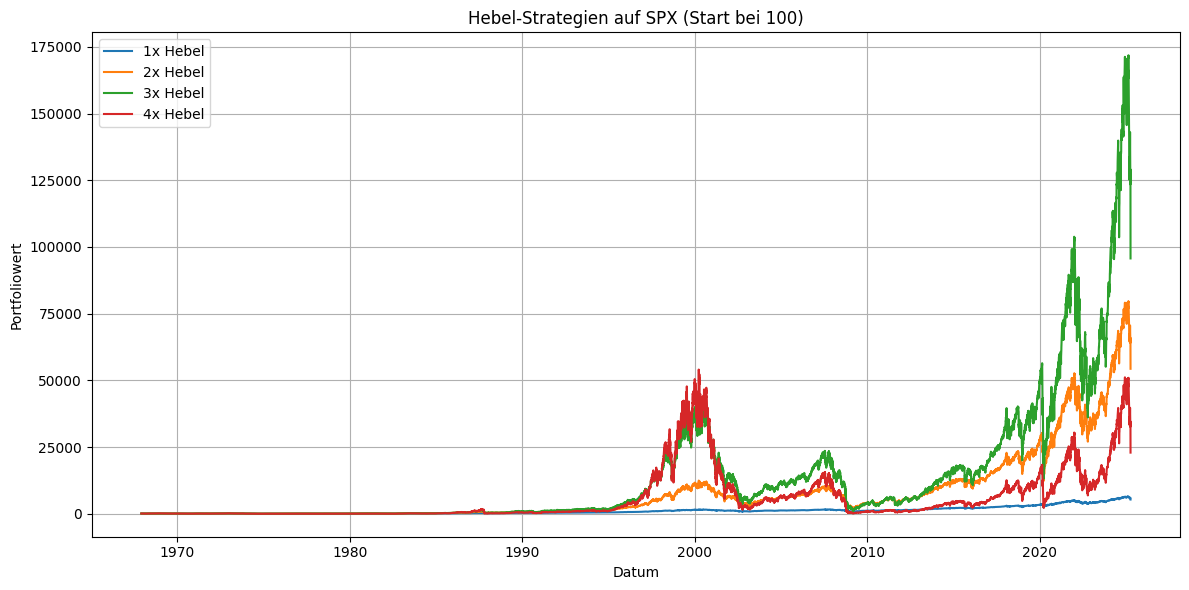

In [31]:
plt.figure(figsize=(12, 6))
for lev in leverage_factors:
    plt.plot(spx["Date"], spx[f"Leverage_{lev}x"], label=f"{lev}x Hebel")

plt.title("Hebel-Strategien auf SPX (Start bei 100)")
plt.xlabel("Datum")
plt.ylabel("Portfoliowert")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
